___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcontent.assets.pressassociation.io%2F2020%2F04%2F16223726%2F725547d0-c612-4dc8-94d5-7becbd1bc2c3.jpg&f=1&nofb=1&ipt=84337b824414b8b8a3ebb27b7ffeee8253a22234114accfef6ded7832a4ae7e8" width="180px" height="180px" />


# <font color= #bbc28d> **Neural Style Transfer** </font>
#### <font color= #2E9AFE> `Project 2 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 12/10/2025.

___

<p style="text-align:right;"> Image retrieved from: https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcontent.assets.pressassociation.io%2F2020%2F04%2F16223726%2F725547d0-c612-4dc8-94d5-7becbd1bc2c3.jpg&f=1&nofb=1&ipt=84337b824414b8b8a3ebb27b7ffeee8253a22234114accfef6ded7832a4ae7e8</p>

In [1]:
# Imports

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Visualizar imágenes
from PIL import Image
import matplotlib.pyplot as plt

# Modelado y transformaciones de imágenes
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

# Interfax
import gradio as gr

c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Configurando PyTorch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cuda


# Carga de Imágenes

In [12]:
size = 512 if torch.cuda.is_available() else 128 # Para que, si no se tiene GPU, las imágenes sean más pequeñas y si puedan cargar
print(size)

# Transformación de imágenes
loader = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

# Función para cargar imágenes fácilmente

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

512


In [13]:
# Example with style image of Picasso and Chilean volcano

style_example = image_loader("style_img/TresMusicos_Picasso.jpg")
content_example = image_loader("content/Paisaje1_Chile.jpg")

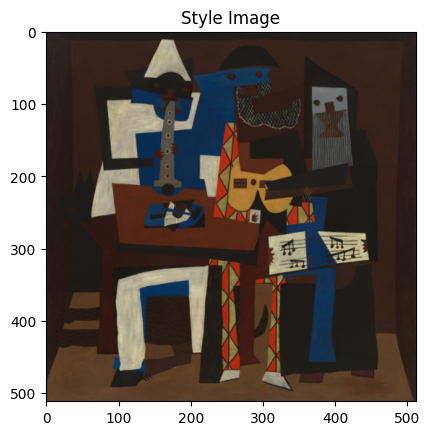

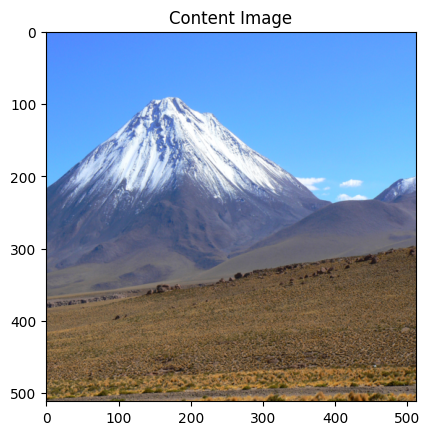

In [15]:
# Pre-visualización de imágenes ya procesadas

to_pil = transforms.ToPILImage()

def show_image(transfomred_image, title=None):
    image = transfomred_image.cpu().clone()
    image = image.squeeze(0)
    image = to_pil(image)

    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
show_image(style_example, title="Style Image")

plt.figure()
show_image(content_example, title="Content Image")

# Loss functions

In [25]:
# Content Loss

class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()

        self.target = target.detach()
    
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [26]:
# Style Loss

def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a*b, c*d)

    G = torch.mm(features, features.t())

    return G.div(a*b*c*d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()

        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Importando Modelo

In [17]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\pixta/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 114MB/s]  


# Normalización de Imágenes para los modelos

In [19]:
# Especificaciones del modelo específico
mean_standard = torch.tensor([0.485, 0.456, 0.406])
std_standard = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [38]:
# Style and content losses

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style, content, 
                               content_layers=content_layers, style_layers = style_layers):
    
    #Normalización
    normalization = Normalization(normalization_mean, normalization_std)

    #Losses
    content_losses = []
    style_losses = []

    # Modelo de normalización
    model = nn.Sequential(normalization)

    i = 0 # Para las diferentes tipos de capas conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError("No se reconoce una capa")
        
        model.add_module(name, layer)

        if name in content_layers:
            # Content Loss
            target = model(content).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            # Style Loss
            target = model(style).detach()
            style_loss = StyleLoss(target)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)
    
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i+1)]

    return model, style_losses, content_losses

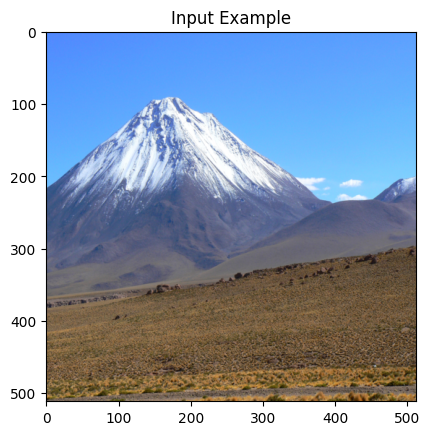

In [22]:
# Input image -> Content Clone

input_example = content_example.clone()

plt.figure()
show_image(input_example, title="Input Example")

# Gradient Descent

In [21]:
def get_input_optimizer(input_image):
    optimizer = optim.LBFGS([input_image])
    return optimizer

In [40]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content, style, input, num_steps=300,
                       style_weight = 1e3, content_weight = 1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style, content)

    input.requires_grad_(True)
    model.train()
    for i in model.parameters():
        i.requires_grad_(False)

    optimizer = get_input_optimizer(input)

    run = [0]

    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'Run {run[0]}')
                print(f'Style Loss: {style_score:4f}. Content Loss: {content_score:4f}')

                return style_score + content_score
            
            return loss
            
        optimizer.step(closure)

    with torch.no_grad():
        input.clamp_(0, 1)
    
    return input

Run 50
Style Loss: 0.967077. Content Loss: 1.390567
Run 100
Style Loss: 0.945099. Content Loss: 1.152132
Run 150
Style Loss: 0.938418. Content Loss: 1.063205
Run 200
Style Loss: 0.937887. Content Loss: 1.008473
Run 250
Style Loss: 0.939766. Content Loss: 0.970562
Run 300
Style Loss: 0.941038. Content Loss: 0.945517


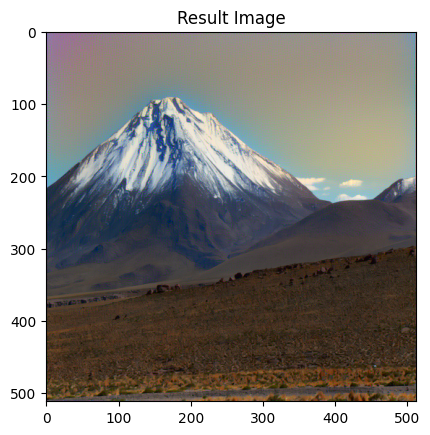

In [41]:
output = run_style_transfer(cnn, mean_standard, std_standard, content_example, style_example, input_example)

plt.figure()
show_image(output, title="Result Image")

# <font color= #bbc28d> **Model Control** </font>

In [ ]:
def image_style_transfer(input_img, style_percent, color, texture):

    # Aquí insertaríamos el modelo
    # Y lo ejecutaríamos sobre input_img
    output_img = input_img

    return output_img

demo = gr.Interface(image_style_transfer, inputs=[gr.Image(), "slider", "slider", "slider"],
                    outputs= ["image"])
demo.launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\fastapi\applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\starlette\middleware\errors.py", line 